# Guest Blog: 10 minutes from pandas to Koalas

## Conversion from pandas to Koalas

In [1]:
import numpy as np
import pandas as pd
import databricks.koalas as ks

### Object creation

In [2]:
# Create a pandas Series
pser = pd.Series([1, 3, 5, np.nan, 6, 8]) 
# Create a Koalas Series
kser = ks.Series([1, 3, 5, np.nan, 6, 8])
# Create a Koalas Series by passing a pandas Series
kser = ks.Series(pser)
kser = ks.from_pandas(pser)

In [3]:
pser

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [4]:
kser

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
Name: 0, dtype: float64

In [5]:
kser.sort_index()

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
Name: 0, dtype: float64

In [6]:
# Creates Pandas DataFrame
pdf = pd.DataFrame({'A': np.random.rand(5),
                    'B': np.random.rand(5)})
# Creates Koalas DataFrame
kdf = ks.DataFrame({'A': np.random.rand(5),
                    'B': np.random.rand(5)})
# Create a Koalas DataFrame by passing a pandas DataFrame
kdf = ks.DataFrame(pdf)
kdf = ks.from_pandas(pdf)

In [7]:
pdf

,A,B
0,0.291837,0.891316
1,0.150306,0.369052
2,0.395687,0.935860
3,0.323141,0.877654
4,0.410437,0.036879


In [8]:
kdf.sort_index()

,A,B
0,0.291837,0.891316
1,0.150306,0.369052
2,0.395687,0.935860
3,0.323141,0.877654
4,0.410437,0.036879


### Viewing data

In [9]:
kdf.head(2)

,A,B
0,0.291837,0.891316
1,0.150306,0.369052


In [10]:
kdf.describe()

,A,B
count,5.000000,5.000000
mean,0.314281,0.622152
std,0.104095,0.400857
min,0.150306,0.036879
25%,0.291837,0.369052
50%,0.323141,0.877654
75%,0.395687,0.891316
max,0.410437,0.935860


In [11]:
kdf.sort_values(by='B')

,A,B
4,0.410437,0.036879
1,0.150306,0.369052
3,0.323141,0.877654
0,0.291837,0.891316
2,0.395687,0.935860


In [12]:
kdf.transpose()

,0,1,2,3,4
A,0.291837,0.150306,0.395687,0.323141,0.410437
B,0.891316,0.369052,0.935860,0.877654,0.036879


In [13]:
from databricks.koalas.config import set_option, get_option
ks.get_option('compute.max_rows')

1000

In [14]:
ks.set_option('compute.max_rows', 2000)
ks.get_option('compute.max_rows')

2000

### Selection

In [15]:
kdf['A']  # or kdf.A

0    0.291837
1    0.150306
2    0.395687
3    0.323141
4    0.410437
Name: A, dtype: float64

In [16]:
kdf[['A', 'B']]

,A,B
0,0.291837,0.891316
1,0.150306,0.369052
2,0.395687,0.935860
3,0.323141,0.877654
4,0.410437,0.036879


In [17]:
kdf.loc[1:2]

,A,B
1,0.150306,0.369052
2,0.395687,0.935860


In [18]:
kdf.B[1:2]

1    0.369052
2    0.935860
Name: B, dtype: float64

In [19]:
kdf.iloc[1]

A    0.150306
B    0.369052
Name: 1, dtype: float64

In [20]:
kdf.iloc[:3, 1:2]

,B
0,0.891316
1,0.369052
2,0.935860


In [21]:
kdf.iloc[1:3, 1]

1    0.369052
2    0.935860
Name: B, dtype: float64

In [22]:
kser = ks.Series([100, 200, 300, 400, 500], index=[0, 1, 2, 3, 4])
kdf['C'] = kser

ValueError: Cannot combine the series or dataframe because it comes from a different dataframe. In order to allow this operation, enable 'compute.ops_on_diff_frames' option.

In [23]:
# Those are needed for managing options
from databricks.koalas.config import set_option, reset_option
set_option("compute.ops_on_diff_frames", True)
kdf['C'] = kser
# Reset to default to avoid potential expensive operation in the future
reset_option("compute.ops_on_diff_frames")
kdf

,A,B,C
0,0.291837,0.891316,100
1,0.150306,0.369052,200
3,0.323141,0.877654,400
2,0.395687,0.935860,300
4,0.410437,0.036879,500


### Applying Python function with pandas object

In [24]:
kdf.apply(np.cumsum)

,A,B,C
0,0.291837,0.891316,100
1,0.442142,1.260368,300
3,0.765283,2.138021,700
2,1.160970,3.073881,1000
4,1.571407,3.110761,1500


In [25]:
kdf.apply(np.cumsum, axis=1)

,A,B,C
0,0.291837,1.183153,101.183153
1,0.150306,0.519357,200.519357
3,0.323141,1.200794,401.200794
2,0.395687,1.331547,301.331547
4,0.410437,0.447316,500.447316


In [26]:
kdf.apply(lambda x: x ** 2)

,A,B,C
0,0.085169,0.794445,10000
1,0.022592,0.136199,40000
3,0.104420,0.770276,160000
2,0.156568,0.875834,90000
4,0.168458,0.001360,250000


In [27]:
def square(x) -> ks.Series[np.float64]:
    return x ** 2

In [28]:
kdf.apply(square)

,A,B,C
0,0.156568,0.875834,90000.0
1,0.168458,0.001360,250000.0
2,0.085169,0.794445,10000.0
3,0.104420,0.770276,160000.0
4,0.022592,0.136199,40000.0


In [29]:
pd.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A    1000
dtype: int64

In [30]:
ks.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A     165
A     580
A     331
A     497
A     829
A     414
A     746
A     663
A     912
A    1000
A     248
A      82
Name: 0, dtype: int64

In [31]:
ks.set_option('compute.shortcut_limit', 1001)
ks.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A    1000
Name: 0, dtype: int64

### Grouping Data

In [32]:
kdf.groupby('A').sum()

,B,C
A,,
0.395687,0.935860,300
0.323141,0.877654,400
0.291837,0.891316,100
0.410437,0.036879,500
0.150306,0.369052,200


In [33]:
kdf.groupby(['A', 'B']).sum()

,,C
A,B,
0.323141,0.877654,400
0.291837,0.891316,100
0.395687,0.935860,300
0.410437,0.036879,500
0.150306,0.369052,200


### Plotting

In [34]:
# This is needed for visualizing plot on notebook
%matplotlib inline
from databricks.koalas.config import option_context

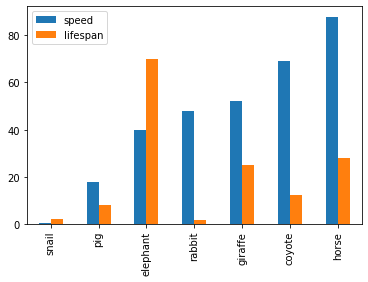

In [35]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
kdf = ks.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
kdf.plot.bar()

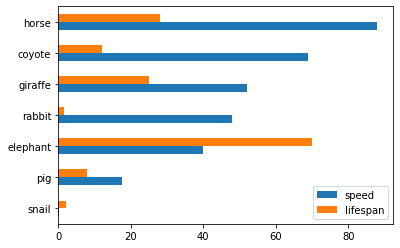

In [36]:
kdf.plot.barh()

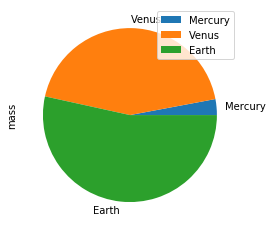

In [37]:
kdf = ks.DataFrame({'mass': [0.330, 4.87, 5.97],
                    'radius': [2439.7, 6051.8, 6378.1]},
                   index=['Mercury', 'Venus', 'Earth'])
kdf.plot.pie(y='mass')

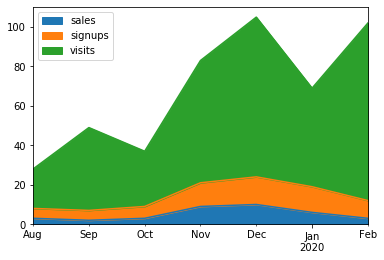

In [38]:
kdf = ks.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6, 3],
    'signups': [5, 5, 6, 12, 14, 13, 9],
    'visits': [20, 42, 28, 62, 81, 50, 90],
}, index=pd.date_range(start='2019/08/15', end='2020/03/09',
                       freq='M'))
kdf.plot.area()

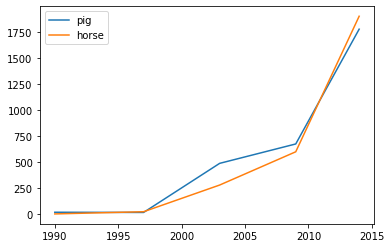

In [39]:
kdf = ks.DataFrame({'pig': [20, 18, 489, 675, 1776],
                    'horse': [4, 25, 281, 600, 1900]},
                   index=[1990, 1997, 2003, 2009, 2014])
kdf.plot.line()

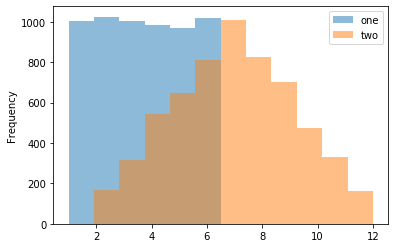

In [40]:
kdf = pd.DataFrame(
    np.random.randint(1, 7, 6000),
    columns=['one'])
kdf['two'] = kdf['one'] + np.random.randint(1, 7, 6000)
kdf = ks.from_pandas(kdf)
kdf.plot.hist(bins=12, alpha=0.5)

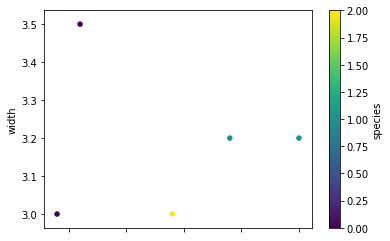

In [41]:
kdf = ks.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
                    [6.4, 3.2, 1], [5.9, 3.0, 2]],
                   columns=['length', 'width', 'species'])
kdf.plot.scatter(x='length',
                 y='width',
                 c='species',
                 colormap='viridis')

### Missing Functionalities and Workarounds in Koalas

#### DataFrame.to_pandas

In [42]:
kidx = kdf.index

In [43]:
kidx.to_list()

PandasNotImplementedError: The method `pd.Index.to_list()` is not implemented. If you want to collect your data as an NumPy array, use 'to_numpy()' instead.

In [44]:
kidx.to_pandas().to_list()

[0, 1, 2, 3, 4]

In [45]:
long_series = ks.Series(np.random.randn(1000))
long_series.tail(3)

PandasNotImplementedError: The method `pd.Series.tail()` is not implemented yet.

In [46]:
# same as `ks.from_pandas(long_series.to_pandas().tail(3))`
pdf = long_series.to_pandas().tail(3)
pdf

997   -0.957431
998    0.863949
999    0.739750
Name: 0, dtype: float64

In [47]:
kdf = ks.DataFrame({'A': 1.,
                    'B': ks.Timestamp('20130102'),
                    'C': ks.Series(1, index=list(range(4)), dtype='float32'),
                    'D': np.array([3] * 4, dtype='int32'),
                    'F': 'foo'})

AttributeError: module 'databricks.koalas' has no attribute 'Timestamp'

### Native Support for pandas Objects and Functions 

In [48]:
kdf = ks.DataFrame({'A': 1.,
                    'B': pd.Timestamp('20130102'),
                    'C': pd.Series(1, index=list(range(4)), dtype='float32'),
                    'D': np.array([3] * 4, dtype='int32'),
                    'F': 'foo'})

#### DataFrame.map_in_pandas

In [49]:
i = pd.date_range('2018-04-09', periods=2000, freq='1D1min')
ts = ks.DataFrame({'A': ['timestamp']}, index=i)
ts.between_time('0:15', '0:16')

PandasNotImplementedError: The method `pd.DataFrame.between_time()` is not implemented yet.

In [50]:
ts.to_pandas().between_time('0:15', '0:16')

,A
2018-04-24 00:15:00,timestamp
2018-04-25 00:16:00,timestamp
2022-04-04 00:15:00,timestamp
2022-04-05 00:16:00,timestamp


In [51]:
ts.map_in_pandas(func=lambda pdf: pdf.between_time('0:15', '0:16'))

,A
2022-04-04 00:15:00,timestamp
2022-04-05 00:16:00,timestamp
2018-04-24 00:15:00,timestamp
2018-04-25 00:16:00,timestamp


## Working with PySpark

### Conversion from/to PySpark DataFrame


In [52]:
kdf = ks.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]})
sdf = kdf.to_spark()
type(sdf)

pyspark.sql.dataframe.DataFrame

In [53]:
sdf.show()

+---+---+
|  A|  B|
+---+---+
|  1| 10|
|  2| 20|
|  3| 30|
|  4| 40|
|  5| 50|
+---+---+



In [54]:
from databricks.koalas import option_context
with option_context(
        "compute.default_index_type", "distributed-sequence"):
    kdf = sdf.to_koalas()
type(kdf)

databricks.koalas.frame.DataFrame

In [55]:
kdf

,A,B
3,4,40
1,2,20
2,3,30
4,5,50
0,1,10


In [56]:
sdf.to_koalas(index_col='A')

,B
A,
1,10
2,20
3,30
4,40
5,50


### Checking PySpark physical plan

In [57]:
from databricks.koalas import option_context

with option_context(
        "compute.ops_on_diff_frames", True,
        "compute.default_index_type", 'distributed'):
    df = ks.range(10) + ks.range(10)
    df.explain()

== Physical Plan ==
*(5) Project [CASE WHEN isnotnull(__index_level_0__#2434L) THEN __index_level_0__#2434L ELSE __index_level_0__#2444L END AS __index_level_0__#2452L, (id#2432L + id#2442L) AS id#2509L]
+- SortMergeJoin [__index_level_0__#2434L], [__index_level_0__#2444L], FullOuter
   :- *(2) Sort [__index_level_0__#2434L ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(__index_level_0__#2434L, 200)
   :     +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2434L, id#2432L]
   :        +- *(1) Range (0, 10, step=1, splits=12)
   +- *(4) Sort [__index_level_0__#2444L ASC NULLS FIRST], false, 0
      +- ReusedExchange [__index_level_0__#2444L, id#2442L], Exchange hashpartitioning(__index_level_0__#2434L, 200)


In [58]:
with option_context(
        "compute.ops_on_diff_frames", False,
        "compute.default_index_type", 'distributed'):
    df = ks.range(10)
    df = df + df
    df.explain()

== Physical Plan ==
*(1) Project [__index_level_0__#2518L, (id#2516L + id#2516L) AS id#2527L]
+- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2518L, id#2516L]
   +- *(1) Range (0, 10, step=1, splits=12)


### Caching

In [59]:
with option_context("compute.default_index_type", 'distributed'):
    df = ks.range(10)
    new_df = (df + df).cache()  # `(df + df)` is cached here as `df`
    new_df.explain()

== Physical Plan ==
*(1) InMemoryTableScan [__index_level_0__#2537L, id#2546L]
   +- InMemoryRelation [__index_level_0__#2537L, id#2546L, __natural_order__#2540L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Project [__index_level_0__#2537L, (id#2535L + id#2535L) AS id#2546L, __natural_order__#2540L]
            +- *(1) Project [__index_level_0__#2537L, id#2535L, monotonically_increasing_id() AS __natural_order__#2540L]
               +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2537L, id#2535L]
                  +- *(1) Range (0, 10, step=1, splits=12)


In [60]:
with (df + df).cache() as df:
    df.explain()

== Physical Plan ==
*(1) InMemoryTableScan [__index_level_0__#2537L, id#2585L]
   +- InMemoryRelation [__index_level_0__#2537L, id#2585L, __natural_order__#2540L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Project [__index_level_0__#2537L, (id#2535L + id#2535L) AS id#2546L, __natural_order__#2540L]
            +- *(1) Project [__index_level_0__#2537L, id#2535L, monotonically_increasing_id() AS __natural_order__#2540L]
               +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2537L, id#2535L]
                  +- *(1) Range (0, 10, step=1, splits=12)
